<h1>Transfer Learning: VGG Model</h1>
<hr>
<p>Trying to distinguish and and bees with the help of VGG Model.</p>

In [1]:
# importing data libraries.
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git
!ls ants_and_bees/train

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
batch_size = 20
transformation_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 

transformation_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transformation_train)
test_dataset  = datasets.ImageFolder(root='ants_and_bees/val',  transform=transformation_test)
classes = ['ant', 'bee'] 

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [5]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([20, 3, 224, 224])
torch.Size([20])


In [6]:
# plots an image.
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

# plots an image.
def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

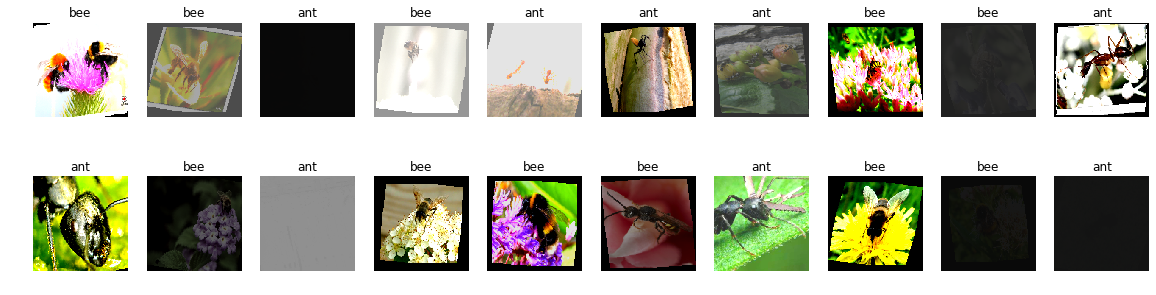

In [7]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [8]:
vgg_model = models.vgg16(pretrained=True)
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
for feature_extraction_layer in vgg_model.features.parameters():
    feature_extraction_layer.requires_grad = False

last_layer_inputs = vgg_model.classifier[6].in_features
last_layer = nn.Linear( last_layer_inputs, len(classes) )
vgg_model.classifier[6] = last_layer
vgg_model.to( device )

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [10]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.0001)

In [11]:
numOfEpochs = 10
train_count = len(train_loader) * batch_size
test_count  = len(test_loader)  * batch_size
train_losses = []
test_losses  = []
train_acurracies = []
test_acurracies  = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
    
        # calculating loss for training
        # dataset for the current batch.
        train_labels_head = vgg_model.forward(train_images)
        loss = criterion(train_labels_head, train_labels)
    
        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max( train_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
    
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # testing the current model within the current epoch.
    for test_images, test_labels in test_loader:
    
        # registering test images and labels 
        # to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
        # calculating loss for test 
        # dataset for the current batch.
        test_labels_head = vgg_model.forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( test_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc += acurracy 
        test_loss += loss.item()
 
    # printing out the training dataset 
    # results for the current batch.
    train_acc = float(train_acc.float()) / train_count
    train_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")
  
    # printing out the test dataset 
    # results for the current batch.
    test_acc = float(test_acc.float()) / test_count
    test_acurracies.append( test_acc )
    print("Test Acurracy: " + str( float(test_acc) ))    
    
    test_loss = test_loss / test_count
    test_losses.append( test_loss )
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.5807692307692308
Train Loss: 0.03368373742470374

Test Acurracy: 0.86875
Test Loss: 0.013944436609745026
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.7730769230769231
Train Loss: 0.01878095974142735

Test Acurracy: 0.875
Test Loss: 0.013626693189144135
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.7769230769230769
Train Loss: 0.014481170246234307

Test Acurracy: 0.88125
Test Loss: 0.01193241896107793
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.8
Train Loss: 0.014328482059332041

Test Acurracy: 0.8625
Test Loss: 0.013364830380305648
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Acurracy: 0.7846153846153846
Tra

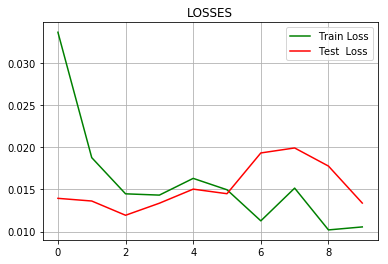

In [12]:
# plotting loss graph.
plt.title("LOSSES")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses,  label = "Test  Loss", color= "red")
plt.legend()
plt.grid()

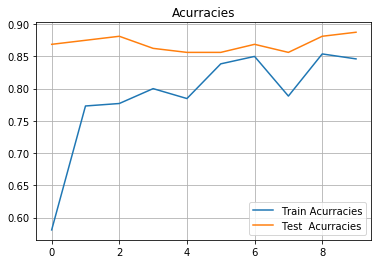

In [13]:
plt.title("Acurracies")
plt.plot(train_acurracies, label = "Train Acurracies")
plt.plot(test_acurracies,  label = "Test  Acurracies")
plt.legend()
plt.grid()

In [14]:
test_iterator = iter(test_loader)
test_images, test_labels = test_iterator.next()
test_labels = test_labels.to( device )
test_images = test_images.to( device )
test_predict = vgg_model.forward(test_images)
test_predict = torch.max( test_predict , 1)[1] 
print( test_images.shape )
print( test_labels.shape )
print( test_predict.shape )

torch.Size([20, 3, 224, 224])
torch.Size([20])
torch.Size([20])


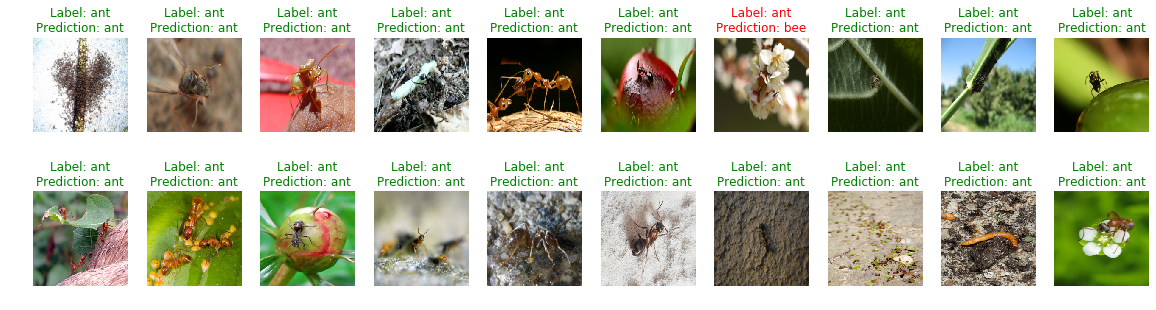

In [15]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img_cuda(test_images[i])
    title = "Label: " + str( classes[ test_labels[i] ] ) + "\n" + "Prediction: " + str(classes[ test_predict[i] ]) 

    plt.imshow(image) 
    plt.axis('off')

    if( str( classes[ test_labels[i] ] ) == str(classes[ test_predict[i] ] )):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")

plt.show()

In [16]:
acurracy = torch.sum( test_predict == test_labels )
print( float( acurracy) / batch_size  )

0.95
